### Friday, December 15, 2023

Running this in the hfpt_Dec14 container, using the "meta-llama/Llama-2-13b-hf" model.

Nice! This still all works!

### Sunday, November 19, 2023

I am going to look into the datasets found at [LLMDataHub: Awesome Datasets for LLM Training](https://github.com/Zjh-819/LLMDataHub) 

Let's go with [this](https://huggingface.co/datasets/THUDM/webglm-qa) dataset. This data has been loaded into the data/webglm-qa folder.

Ok Nice! I got this to run!

Let's try this on "meta-llama/Llama-2-13b-hf" shall we ... Nice! It also works!

### Friday, November 17, 2023

[How to fine-tune Llama 2 on your own data](https://brev.dev/blog/fine-tuning-llama-2-your-own-data)

https://github.com/brevdev/notebooks/blob/main/llama2-finetune.ipynb

This notebook uses "meta-llama/Llama-2-7b-hf"

Wow Really!? I need to create my own dataset!? ...

In [1]:
# !ls /home/rob/Data2/huggingface/transformers
!ls /root/.cache/huggingface/hub

models--bert-base-uncased  models--meta-llama--Llama-2-13b-hf  version.txt


In [2]:
# ! rm -rf /home/rob/Data2/huggingface/transformers/models--meta-llama--Llama-2-7b-chat-hf

# docker cp /home/rob/Data3/huggingface/transformers/models--meta-llama--Llama-2-7b-hf c9b676310ea0://home/rob/Data2/huggingface/transformers
# Successfully copied 13.5GB to c9b676310ea0://home/rob/Data2/huggingface/transformer

In [2]:
# only target the 4090 ... 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning Llama 2 7B on your own data 🤙

Welcome!

In this notebook and tutorial, we will fine-tune Meta's [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b).

## Watch the accompanying video walk-through (but for Mistral) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)! If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/NVDyv7TUgJ) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/NVDyv7TUgJ) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
I used a GPU and dev environment from [brev.dev](https://brev.dev). Provision a pre-configured GPU in one click [here](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&name=llama2-7b-finetune) (a single A10G or L4 should be enough for this dataset; anything with >= 24GB GPU Memory. You may need more GPUs and/or Memory if your sequence max_length is larger than 512). Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10** and CUDA 11.7) and click the "Build" button to build your Verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [3]:
# # You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib

### 0. Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [3]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 1. Load Dataset

Here's where you load your own data. You want the data formatted in a `.jsonl` file, structured something like this:

#### Preparing data

To prepare your dataset for loading, all you need is a `.jsonl` file structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```

If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will combine all your features into one input string.


In [4]:
from datasets import load_dataset

dataFolder = 'data/webglm-qa/'

# train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')  
# eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')

train_dataset = load_dataset('json', data_files=dataFolder + 'train.jsonl', split='train')  
eval_dataset = load_dataset('json', data_files=dataFolder + 'validation.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
eval_dataset[0]

{'question': 'what measures do film makers take to protect child actors in horror films or emotionally distressing scenes?',
 'answer': 'Directors must be mindful of a child actor’s well-being and take care to shield the children they are working with from some darker themes of the material[1]. They usually try and avoid exposing the very young actors to the violence of such scenes, e.g. by clever dubbing and editing[3]. There are laws that require them to do so, such as if a child is not comfortable with what they will be exposed with (such as mock rape and murder scenes)[4], the director can not under law be allowed to use that child for that particular scene. Laws also protect children from certain flavors of exploitation, particularly of a sexual nature.',
 'references': ['Not all stories about childhood are suitable for children. It is not uncommon for filmmakers to explore darker aspects of childhood in their films. Although telling these stories is important, if adequate protect

### Formatting prompts
Then create a formatting_func to structure training examples as prompts. In my case, my data was just notes like this:

```json
{"note": "note-for-model-to-predict"}
{"note": "note-for-model-to-predict-1"}
{"note": "note-for-model-to-predict-2"}
```
So the formatting_func I used was:
```python
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text
```

In [6]:
def formatting_func(example):
    #text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    text = f"### Question: {example['question']}\n ### Answer: {example['answer']}"
    return text

### 2. Load Base Model

Let's now load Llama 2 7B - `meta-llama/Llama-2-7b-hf` - using 4-bit quantization!

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"

# Let's try the bigger model ...
base_model_id = "meta-llama/Llama-2-13b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/43579 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
# I added this because I want to know the actual value for the maximum length, and 
# because we can just past lengths into the plot_data_lengths function ...
lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
dsMaxLength = max(lengths)
print(dsMaxLength)

693


Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

In [11]:
import matplotlib.pyplot as plt

# def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
def plot_data_lengths(lengths):

    # lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    # lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


44579


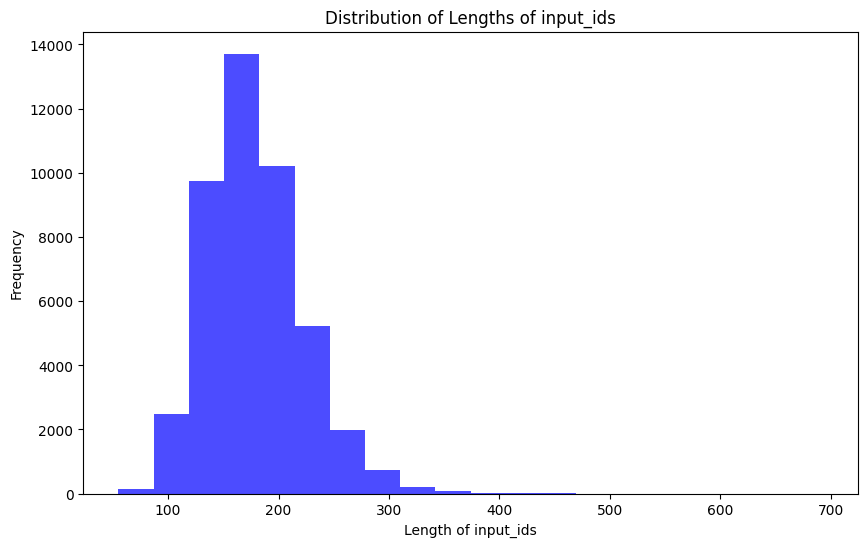

In [12]:
# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)
plot_data_lengths(lengths)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [13]:
max_length = 512 # This was an appropriate max length for my dataset

max_length = 300 # Looking at the graph, I am going to choose ...

max_length = 400 # Let's try an even higher value ...

max_length = 512 # why not, right? ...

# lets use the actual max_length of our dataset ...
max_length = dsMaxLength + 2

def generate_and_tokenize_prompt2(prompt):

    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    
    result["labels"] = result["input_ids"].copy()

    return result

In [14]:
max_length

695

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/43579 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [16]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Now all the samples should be the same length, `max_length`.

44579


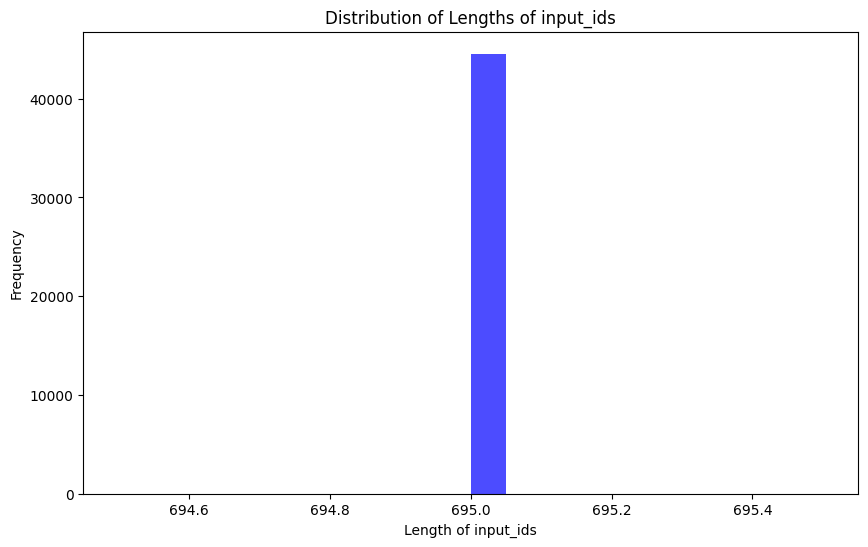

In [17]:
# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

tokenizedLengths = [len(x['input_ids']) for x in tokenized_train_dataset]
tokenizedLengths += [len(x['input_ids']) for x in tokenized_val_dataset]
plot_data_lengths(tokenizedLengths)

# 25.3s

### How does the base model do?

Optionally, you can check how Llama 2 7B does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [18]:
eval_prompt = """ Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55

### Health Score:
"""

The `eval_prompt` I used was:

In [19]:
eval_prompt = " The following is a note by Eevee the Dog: # "

In [20]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 The following is a note by Eevee the Dog: #  The Best Online Gambling Sites in India
Online gambling is a popular activity in India, with a wide variety of games available to players. From casino games to sports betting, there is something for everyone. With so many options available, it can be difficult to know where to start. To help you get started, we have compiled a list of the best online gambling sites in India.
1. 10CRIC
10CRIC is one of the most popular online gambling sites in India. It offers a wide range of casino games, including slots, table games, and live dealer games. The site also offers a variety of sports betting options, including cricket, football, and horse racing. 10CRIC is a great choice for those looking for a comprehensive gambling experience.
2. Betway
Betway is another popular online gambling site in India. It offers a wide range of casino games, including slots, table games, and live dealer games. The site also offers a variety of sports betting options, 

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [21]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [22]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [23]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 126361600 || all params: 6798341120 || trainable%: 1.8587122618524914


See how the model looks different now, with the LoRA adapters added:

In [25]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [26]:
# !pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of

### 5. Run Training!

I didn't have a lot of training samples, so I used only 500 steps. I found that the end product worked well.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`llama2-7b-journal-finetune`) as your final model in step 6 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [27]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [28]:
import transformers
from datetime import datetime

project = "journal-finetune"
# base_model_name = "llama2-7b"
base_model_name = "llama2-13b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
       # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
%%time

trainer.train()

# 13B model with max_length = 695 14720 MiB VRAM
# CPU times: user 35min 3s, sys: 18min 12s, total: 53min 16s
# Wall time: 53min 31s

# 56m 44.5s on 13B model with max_length = 695 15222 MiB VRAM
# 25m 31.8s on 13B model with max_length = 300
# 14m 15.6s on 7B model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,No log,1.635948
100,No log,1.615770
150,No log,1.609987
200,No log,1.606732
250,No log,1.604123
300,No log,1.599560
350,No log,1.598060
400,No log,1.597148
450,No log,1.596374
500,1.621700,1.596051


Checkpoint destination directory ./llama2-13b-journal-finetune/checkpoint-50 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.8/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.8/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./llama2-13b-journal-finetune/checkpoint-100 already exists and is n

CPU times: user 35min 3s, sys: 18min 12s, total: 53min 16s
Wall time: 53min 31s


TrainOutput(global_step=500, training_loss=1.621734130859375, metrics={'train_runtime': 3207.8264, 'train_samples_per_second': 0.312, 'train_steps_per_second': 0.156, 'total_flos': 5.41198692864e+16, 'train_loss': 1.621734130859375, 'epoch': 0.02})

In [30]:
# Empty VRAM ... 
del model
del trainer
import gc
gc.collect()
gc.collect()

0

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Llama 2 7B model from the Huggingface Hub:


(Restart the Kernel, then continue starting with the next cell ...)

In [1]:
# only target the 4090 ... 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"

base_model_id = "meta-llama/Llama-2-13b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/transformers/src/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [3]:
from peft import PeftModel

# ft_model = PeftModel.from_pretrained(base_model, "llama2-7b-journal-finetune/checkpoint-500")
ft_model = PeftModel.from_pretrained(base_model, "llama2-13b-journal-finetune/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [4]:
eval_prompt = " The following is a note by Eevee the Dog, which doesn't share anything too personal: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

# 31.5s

 The following is a note by Eevee the Dog, which doesn't share anything too personal: # 10: I am a dog. I have no thumbs. I don't know how to type. I have a human who types for me. She's named Melanie. She's nice, but she's a little bossy. I like to sleep on her bed, but she says I can't. I like to eat her shoes, but she says I can't. I like to chew on her phone, but she says I can't. I like to lick her face, but she says I can't. I like to chase her cat, but she says I can't. She says I can't do lots of things, but I do them anyway. I don't think she understands me. I don't think she likes me very much. But I love her. I love her a lot.
# 1: I'm a dog. I'm not a very good dog. I'm not a very good dog at all. I'm not a very good dog because I bite. I bite people and things. I bite people because I'm jealous. I bite things because I'm curious. I bite people because I'm angry. I bite things because I'm happy. I bite people because I'm scared. I bite things because I'm excited. I b


### Sweet... it worked! The fine-tuned model now prints out journal entries in my style!

How funny to see it write like me as an angsty teenager.

I hope you enjoyed this tutorial on fine-tuning Llama 2 on your own data. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or [Discord](https://discord.gg/NVDyv7TUgJ).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙